- 정상과 이상에 대한 정확한 라벨이 없기 때문에 지도학습, 준지도학습 알고리즘은 시도할 수 없다.
- 따라서 비지도학습 알고리즘인 AutoEncoder 알고리즘과 이에 파생되는 알고리즘들을 적용하여 비교해볼 것이다.

# CNN-AutoEncoder

- 이미지 변환 데이터

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

c:\Users\ASUS\.conda\envs\morning_torch_doin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 데이터 불러오기

In [2]:
batch_size = 64
learning_rate = 0.0001
num_epoch = 50

In [3]:
with open("../data/image_data.json", "r") as f:
    image_data = json.load(f)

In [4]:
image_data.keys()

dict_keys(['gasf_at', 'gasf_rat', 'gasf_sat', 'gadf_at', 'gadf_rat', 'gadf_sat'])

In [9]:
train_dict = {}
test_dict = {}

for key in image_data.keys():
    data = image_data[key]

    aa = []
    for i, j in zip(data[0], data[1]):
        aa.append((torch.FloatTensor([i]), j))
    aa = tuple(aa)

    train, test = train_test_split(aa, test_size=0.1, random_state=42)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

    train_dict[key] = train_loader
    test_dict[key] = test

In [10]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1), # batch x 16 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1), # batch x 32 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1), # batch x 64 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2) # batch x 64 x 12 x 12
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1), # batch x 128 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1), # batch x 256 x 6 x 6
                        nn.ReLU()
        )

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1), # batch x 128 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1), # batch x 64 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1), # batch x 16 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1), # batch x 1 x 24 x 24
                        nn.ReLU()
        )
            
            
    def forward(self, x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)

        return output

In [11]:
def plot_origin_and_restored(output, image):
    out_img = torch.squeeze(output.cpu().data)
    print(out_img.size())

    for i in range(2):
        plt.subplot(1,2,1)
        plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='rainbow')
        plt.subplot(1,2,2)
        plt.imshow(out_img[i].numpy(),cmap='rainbow')
        plt.show()

In [12]:
from tqdm import tqdm

def train(train_loader, key):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = ConvAutoEncoder()
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_log = []
    for i in range(num_epoch):
        train_loss = []
        for image in tqdm(train_loader):
            optimizer.zero_grad()
            image = image[0].to(device) # index는 제외하고 이미지 배열만 학습
            
            output = model(image)
            
            loss = loss_func(output,image)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        print(f"{i} epochs loss: {np.mean(train_loss)}")
        train_loss_log.append(np.mean(train_loss))
    plot_origin_and_restored(output, image)

    # 학습이 끝난 모델 저장
    torch.save(model, f"./cae_{key}_50.pt")
    torch.save(model.state_dict(), f"./cae_{key}_state_dict_50.pt")

    return train_loss_log, model

100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


0 epochs loss: 0.8772797925131661


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


1 epochs loss: 0.5773009743009295


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


2 epochs loss: 0.5236770468098777


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


3 epochs loss: 0.49814723432064056


100%|██████████| 14/14 [00:05<00:00,  2.44it/s]


4 epochs loss: 0.48282213296209064


100%|██████████| 14/14 [00:05<00:00,  2.41it/s]


5 epochs loss: 0.47413079014846254


100%|██████████| 14/14 [00:06<00:00,  2.33it/s]


6 epochs loss: 0.4670521020889282


100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


7 epochs loss: 0.4632603313241686


100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


8 epochs loss: 0.459320136478969


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


9 epochs loss: 0.4569199063948223


100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


10 epochs loss: 0.45409791810171946


100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


11 epochs loss: 0.45217388229710714


100%|██████████| 14/14 [00:05<00:00,  2.44it/s]


12 epochs loss: 0.450325927564076


100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


13 epochs loss: 0.44911343285015654


100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


14 epochs loss: 0.44796267577580046


100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


15 epochs loss: 0.44618916724409374


100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


16 epochs loss: 0.4455203775848661


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


17 epochs loss: 0.4448533590350832


100%|██████████| 14/14 [00:05<00:00,  2.55it/s]


18 epochs loss: 0.4435346743890217


100%|██████████| 14/14 [00:05<00:00,  2.55it/s]


19 epochs loss: 0.4428586257355554


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


20 epochs loss: 0.4431863235575812


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


21 epochs loss: 0.44190792526517597


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


22 epochs loss: 0.44098437471049173


100%|██████████| 14/14 [00:05<00:00,  2.41it/s]


23 epochs loss: 0.4405255338975361


100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


24 epochs loss: 0.4399440437555313


100%|██████████| 14/14 [00:05<00:00,  2.45it/s]


25 epochs loss: 0.43961107092244284


100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


26 epochs loss: 0.4395718659673418


100%|██████████| 14/14 [00:05<00:00,  2.41it/s]


27 epochs loss: 0.43875065658773693


100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


28 epochs loss: 0.4387810102530888


100%|██████████| 14/14 [00:05<00:00,  2.51it/s]


29 epochs loss: 0.4376491074051176


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


30 epochs loss: 0.4377347528934479


100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


31 epochs loss: 0.4367808359009879


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


32 epochs loss: 0.4367823026009968


100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


33 epochs loss: 0.43616483892713276


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


34 epochs loss: 0.4357365646532604


100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


35 epochs loss: 0.4357233409370695


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


36 epochs loss: 0.4352772533893585


100%|██████████| 14/14 [00:05<00:00,  2.45it/s]


37 epochs loss: 0.43493192323616575


100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


38 epochs loss: 0.4347984173468181


100%|██████████| 14/14 [00:05<00:00,  2.51it/s]


39 epochs loss: 0.434288284608296


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


40 epochs loss: 0.4345278718641826


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


41 epochs loss: 0.4342559554747173


100%|██████████| 14/14 [00:05<00:00,  2.57it/s]


42 epochs loss: 0.4332146665879658


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


43 epochs loss: 0.43362702216420856


100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


44 epochs loss: 0.433026237147195


100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


45 epochs loss: 0.43286894261837006


100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


46 epochs loss: 0.4328955646072115


100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


47 epochs loss: 0.4324565338236945


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


48 epochs loss: 0.43216692336968016


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

49 epochs loss: 0.4327337550265448
torch.Size([64, 24, 24])


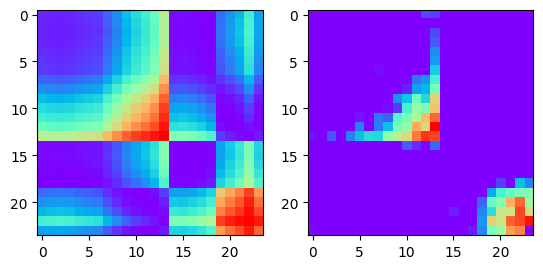

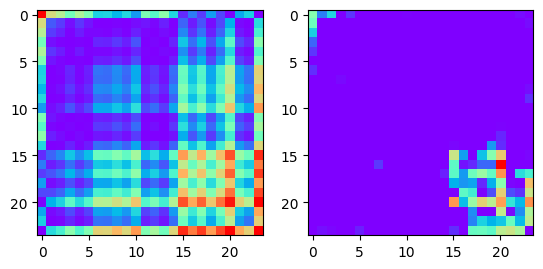

100%|██████████| 14/14 [00:05<00:00,  2.40it/s]


0 epochs loss: 0.7583743014505931


100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


1 epochs loss: 0.4336668998003006


100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


2 epochs loss: 0.377540865114757


100%|██████████| 14/14 [00:05<00:00,  2.47it/s]


3 epochs loss: 0.35496097590242115


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


4 epochs loss: 0.3438969552516937


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


5 epochs loss: 0.33505831020218985


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


6 epochs loss: 0.3300559137548719


100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


7 epochs loss: 0.3249263720852988


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


8 epochs loss: 0.3212765370096479


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


9 epochs loss: 0.31976633412497385


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


10 epochs loss: 0.31680148414203096


100%|██████████| 14/14 [00:05<00:00,  2.47it/s]


11 epochs loss: 0.31542120235306875


100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


12 epochs loss: 0.31294337127889904


100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


13 epochs loss: 0.3118226187569754


100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


14 epochs loss: 0.3102011850902012


100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


15 epochs loss: 0.3106874482972281


100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


16 epochs loss: 0.30991105096680777


100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


17 epochs loss: 0.3087679019996098


100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


18 epochs loss: 0.30763233985219685


100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


19 epochs loss: 0.3062454270465033


100%|██████████| 14/14 [00:05<00:00,  2.60it/s]


20 epochs loss: 0.3057857028075627


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


21 epochs loss: 0.3055111723286765


100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


22 epochs loss: 0.30456293906484333


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


23 epochs loss: 0.3046271311385291


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


24 epochs loss: 0.3045781212193625


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


25 epochs loss: 0.3034273662737438


100%|██████████| 14/14 [00:05<00:00,  2.55it/s]


26 epochs loss: 0.30279411375522614


100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


27 epochs loss: 0.3015479488032205


100%|██████████| 14/14 [00:05<00:00,  2.53it/s]


28 epochs loss: 0.3019094339438847


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


29 epochs loss: 0.3014158180781773


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


30 epochs loss: 0.3023603494678225


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


31 epochs loss: 0.30062524335724966


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


32 epochs loss: 0.300987109541893


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


33 epochs loss: 0.3006263758455004


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


34 epochs loss: 0.29942592339856283


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


35 epochs loss: 0.3001615234783718


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


36 epochs loss: 0.2992908912045615


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


37 epochs loss: 0.29993980697223116


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


38 epochs loss: 0.2986562592642648


100%|██████████| 14/14 [00:05<00:00,  2.58it/s]


39 epochs loss: 0.2989263470683779


100%|██████████| 14/14 [00:05<00:00,  2.80it/s]


40 epochs loss: 0.2982633135148457


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


41 epochs loss: 0.29747420975140165


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


42 epochs loss: 0.29766821435519625


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


43 epochs loss: 0.29853929366384235


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


44 epochs loss: 0.29736572078296114


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


45 epochs loss: 0.29735326554094044


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


46 epochs loss: 0.29642075300216675


100%|██████████| 14/14 [00:05<00:00,  2.54it/s]


47 epochs loss: 0.2967411279678345


100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


48 epochs loss: 0.29700598759310587


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

49 epochs loss: 0.29741306602954865
torch.Size([64, 24, 24])


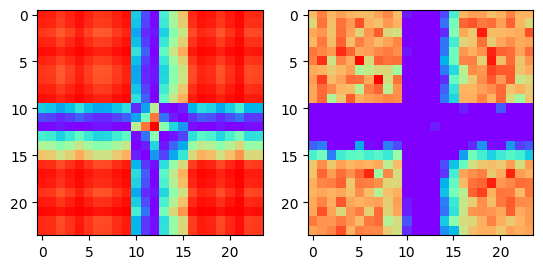

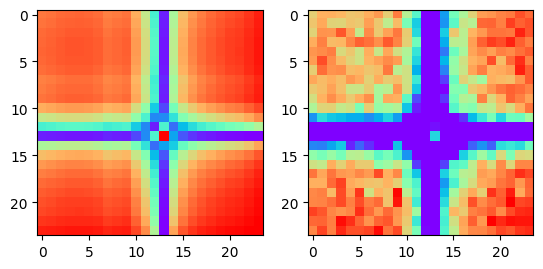

100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


0 epochs loss: 0.9599475860595703


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


1 epochs loss: 0.5850240843636649


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


2 epochs loss: 0.5076472759246826


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


3 epochs loss: 0.47137751962457386


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


4 epochs loss: 0.450499313218253


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


5 epochs loss: 0.4362327243600573


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


6 epochs loss: 0.4268615224531719


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


7 epochs loss: 0.41836540613855633


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


8 epochs loss: 0.413030458348138


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


9 epochs loss: 0.4081217646598816


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


10 epochs loss: 0.40503853985241484


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


11 epochs loss: 0.4014788142272404


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


12 epochs loss: 0.3995328907455717


100%|██████████| 14/14 [00:04<00:00,  2.95it/s]


13 epochs loss: 0.3966359623840877


100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


14 epochs loss: 0.3944063399519239


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


15 epochs loss: 0.39245516061782837


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


16 epochs loss: 0.3909898293869836


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


17 epochs loss: 0.38921381533145905


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


18 epochs loss: 0.38775682023593355


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


19 epochs loss: 0.3870274616139276


100%|██████████| 14/14 [00:05<00:00,  2.57it/s]


20 epochs loss: 0.3849775471857616


100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


21 epochs loss: 0.3839533201285771


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


22 epochs loss: 0.3829057067632675


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


23 epochs loss: 0.38260265971933094


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


24 epochs loss: 0.3810912583555494


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


25 epochs loss: 0.38044350487845285


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


26 epochs loss: 0.3798683839184897


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


27 epochs loss: 0.3784648818629129


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


28 epochs loss: 0.3779440713780267


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


29 epochs loss: 0.3767110918249403


100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


30 epochs loss: 0.3756079780203955


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


31 epochs loss: 0.37550634145736694


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


32 epochs loss: 0.3745142051151821


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


33 epochs loss: 0.3748093396425247


100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


34 epochs loss: 0.37427037741456715


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


35 epochs loss: 0.3742386954171317


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


36 epochs loss: 0.3730019437415259


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


37 epochs loss: 0.37255912167685373


100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


38 epochs loss: 0.37215417836393627


100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


39 epochs loss: 0.3714223631790706


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


40 epochs loss: 0.371308514050075


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


41 epochs loss: 0.3706431175981249


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


42 epochs loss: 0.37018113476889475


100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


43 epochs loss: 0.370277538895607


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


44 epochs loss: 0.3696047748838152


100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


45 epochs loss: 0.36947676965168547


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


46 epochs loss: 0.36919995503766195


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


47 epochs loss: 0.36883836346013205


100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


48 epochs loss: 0.36866254253046854


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

49 epochs loss: 0.3681473902293614
torch.Size([64, 24, 24])


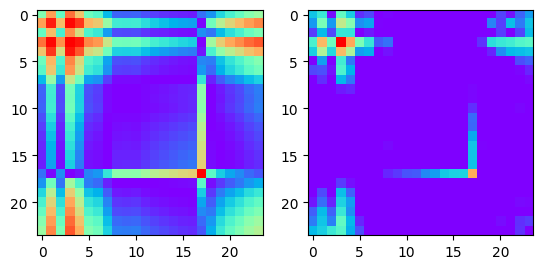

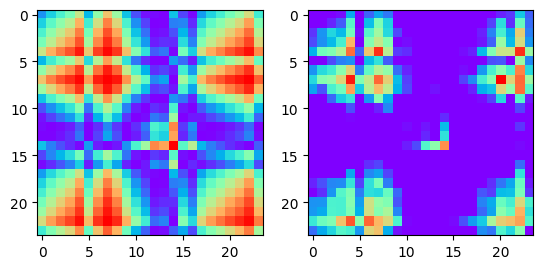

100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


0 epochs loss: 0.6442715376615524


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


1 epochs loss: 0.3578104078769684


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


2 epochs loss: 0.3005571556942804


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


3 epochs loss: 0.27842414591993603


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


4 epochs loss: 0.2674448149544852


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


5 epochs loss: 0.26093548110553194


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


6 epochs loss: 0.2563540978091104


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


7 epochs loss: 0.2528211250901222


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


8 epochs loss: 0.25051519913332804


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


9 epochs loss: 0.24809236079454422


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


10 epochs loss: 0.24616186852966035


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


11 epochs loss: 0.2450492318187441


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


12 epochs loss: 0.2432267474276679


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


13 epochs loss: 0.24201213036264693


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


14 epochs loss: 0.2413505358355386


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


15 epochs loss: 0.24004639152969634


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


16 epochs loss: 0.23916532631431306


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


17 epochs loss: 0.23829547528709685


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


18 epochs loss: 0.23760016156094416


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


19 epochs loss: 0.23686884024313518


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


20 epochs loss: 0.23640708412442887


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


21 epochs loss: 0.23566857406071254


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


22 epochs loss: 0.23514568167073385


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


23 epochs loss: 0.23474532259362085


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


24 epochs loss: 0.2342562090073313


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


25 epochs loss: 0.2335836344531604


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


26 epochs loss: 0.23319586366415024


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


27 epochs loss: 0.2326285285609109


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


28 epochs loss: 0.23250054248741694


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


29 epochs loss: 0.23181810549327306


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


30 epochs loss: 0.23181370965072087


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


31 epochs loss: 0.2310291581920215


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


32 epochs loss: 0.23068343422242574


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


33 epochs loss: 0.23032992333173752


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


34 epochs loss: 0.23012943885156087


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


35 epochs loss: 0.22966189788920538


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


36 epochs loss: 0.22945519856044225


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


37 epochs loss: 0.22905617952346802


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


38 epochs loss: 0.22879402339458466


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


39 epochs loss: 0.228754956807409


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


40 epochs loss: 0.22835785895586014


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


41 epochs loss: 0.22818092576095036


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


42 epochs loss: 0.22791234936032975


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


43 epochs loss: 0.2274889743753842


100%|██████████| 14/14 [00:04<00:00,  2.95it/s]


44 epochs loss: 0.22722968565566198


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


45 epochs loss: 0.2271674850157329


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


46 epochs loss: 0.22678909450769424


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


47 epochs loss: 0.22662931574242456


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


48 epochs loss: 0.22646763495036534


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

49 epochs loss: 0.2264045849442482
torch.Size([64, 24, 24])


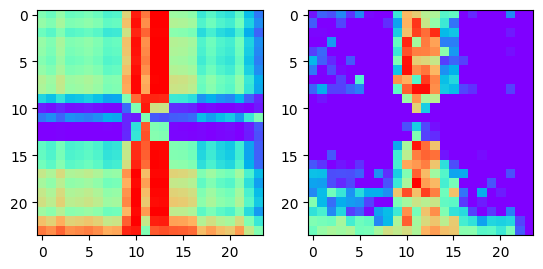

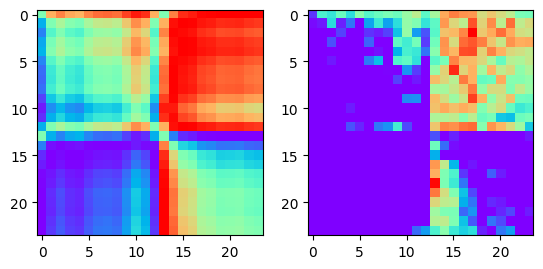

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


0 epochs loss: 0.554535122854369


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


1 epochs loss: 0.30023153339113506


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


2 epochs loss: 0.2586069532803127


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


3 epochs loss: 0.24353540475879396


100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


4 epochs loss: 0.23636905636106217


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


5 epochs loss: 0.2314720739211355


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


6 epochs loss: 0.22756258185420716


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


7 epochs loss: 0.22428907028266362


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


8 epochs loss: 0.22208196456943238


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


9 epochs loss: 0.2185121944972447


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


10 epochs loss: 0.21648935760770524


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


11 epochs loss: 0.2153790912457875


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


12 epochs loss: 0.21315837119306838


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


13 epochs loss: 0.21226787247828074


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


14 epochs loss: 0.21120843717030116


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


15 epochs loss: 0.2103213295340538


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


16 epochs loss: 0.2090866533773286


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


17 epochs loss: 0.20856004421200072


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


18 epochs loss: 0.20760559290647507


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


19 epochs loss: 0.20740094355174474


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


20 epochs loss: 0.20645421530519212


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


21 epochs loss: 0.2061035760811397


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


22 epochs loss: 0.20545454216854914


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


23 epochs loss: 0.20490598039967672


100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


24 epochs loss: 0.20403083307402475


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


25 epochs loss: 0.20363501565796988


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


26 epochs loss: 0.20352114737033844


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


27 epochs loss: 0.20272296134914672


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


28 epochs loss: 0.2023261242679187


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


29 epochs loss: 0.20189775952271052


100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


30 epochs loss: 0.20139339034046447


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


31 epochs loss: 0.20129252012286866


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


32 epochs loss: 0.20092260837554932


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


33 epochs loss: 0.20068342770848954


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


34 epochs loss: 0.1998488221849714


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


35 epochs loss: 0.1997075006365776


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


36 epochs loss: 0.1991810958300318


100%|██████████| 14/14 [00:04<00:00,  2.95it/s]


37 epochs loss: 0.19938671801771438


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


38 epochs loss: 0.1987710435475622


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


39 epochs loss: 0.19821644680840628


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


40 epochs loss: 0.1981481217912265


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


41 epochs loss: 0.1978239832179887


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


42 epochs loss: 0.19750087708234787


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


43 epochs loss: 0.19749525828020914


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


44 epochs loss: 0.1970453698720251


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


45 epochs loss: 0.19655021173613413


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


46 epochs loss: 0.19641027386699403


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


47 epochs loss: 0.19645503695522035


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


48 epochs loss: 0.1957841111080987


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]

49 epochs loss: 0.19575305070195878
torch.Size([64, 24, 24])


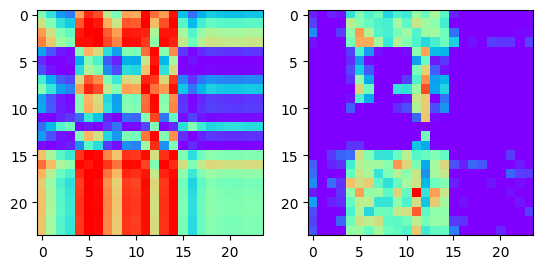

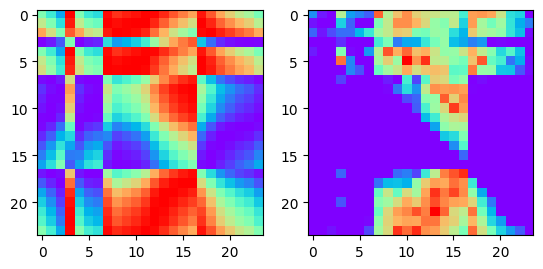

100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


0 epochs loss: 0.5294894980532783


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


1 epochs loss: 0.321081491453307


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


2 epochs loss: 0.2867191731929779


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


3 epochs loss: 0.27157437588487354


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


4 epochs loss: 0.2622314329658236


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


5 epochs loss: 0.2554841148001807


100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


6 epochs loss: 0.25017571449279785


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


7 epochs loss: 0.24588283790009363


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


8 epochs loss: 0.24267223370926722


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


9 epochs loss: 0.23994636216333934


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


10 epochs loss: 0.23723373668534414


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


11 epochs loss: 0.23510198082242692


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


12 epochs loss: 0.23299687675067357


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


13 epochs loss: 0.231610469520092


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


14 epochs loss: 0.2297761429633413


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


15 epochs loss: 0.2282699697784015


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


16 epochs loss: 0.22680584554161345


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


17 epochs loss: 0.22532736297164643


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


18 epochs loss: 0.22441859436886652


100%|██████████| 14/14 [00:04<00:00,  2.88it/s]


19 epochs loss: 0.22286930041653769


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


20 epochs loss: 0.2219534803714071


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


21 epochs loss: 0.22088625601359776


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


22 epochs loss: 0.21970932079213007


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


23 epochs loss: 0.21882651852709906


100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


24 epochs loss: 0.21794563106128148


100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


25 epochs loss: 0.2172196071062769


100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


26 epochs loss: 0.21623766954456056


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


27 epochs loss: 0.21551368811300822


100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


28 epochs loss: 0.21439683650221145


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


29 epochs loss: 0.21344989112445287


100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


30 epochs loss: 0.21324296189205988


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


31 epochs loss: 0.21244551773582185


100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


32 epochs loss: 0.2115104432616915


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


33 epochs loss: 0.21087229358298437


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


34 epochs loss: 0.21034083196095057


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


35 epochs loss: 0.2099253726857049


100%|██████████| 14/14 [00:04<00:00,  2.82it/s]


36 epochs loss: 0.20929185513939177


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


37 epochs loss: 0.2084821600999151


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


38 epochs loss: 0.2081702756030219


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


39 epochs loss: 0.2078168945653098


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


40 epochs loss: 0.2072752501283373


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


41 epochs loss: 0.20680309725659235


100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


42 epochs loss: 0.20658790107284272


100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


43 epochs loss: 0.20609930264098303


100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


44 epochs loss: 0.20547503978013992


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


45 epochs loss: 0.20501128158399037


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


46 epochs loss: 0.20496714860200882


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


47 epochs loss: 0.20465687555926187


100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


48 epochs loss: 0.20427624242646353


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]

49 epochs loss: 0.20410678855010442
torch.Size([64, 24, 24])


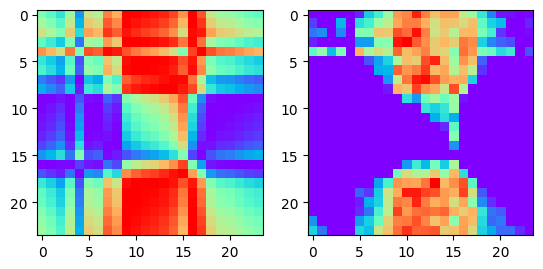

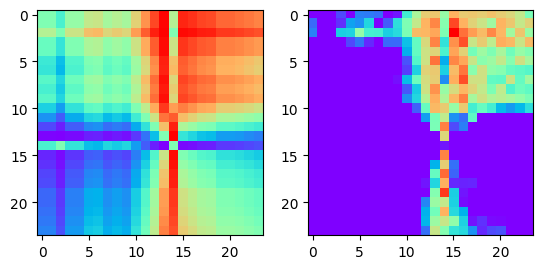

In [13]:
train_loss_log_dict = {}
model_dict = {}

for key, val in train_dict.items():
    train_loss_log_dict[key], model_dict[key] = train(val, key)

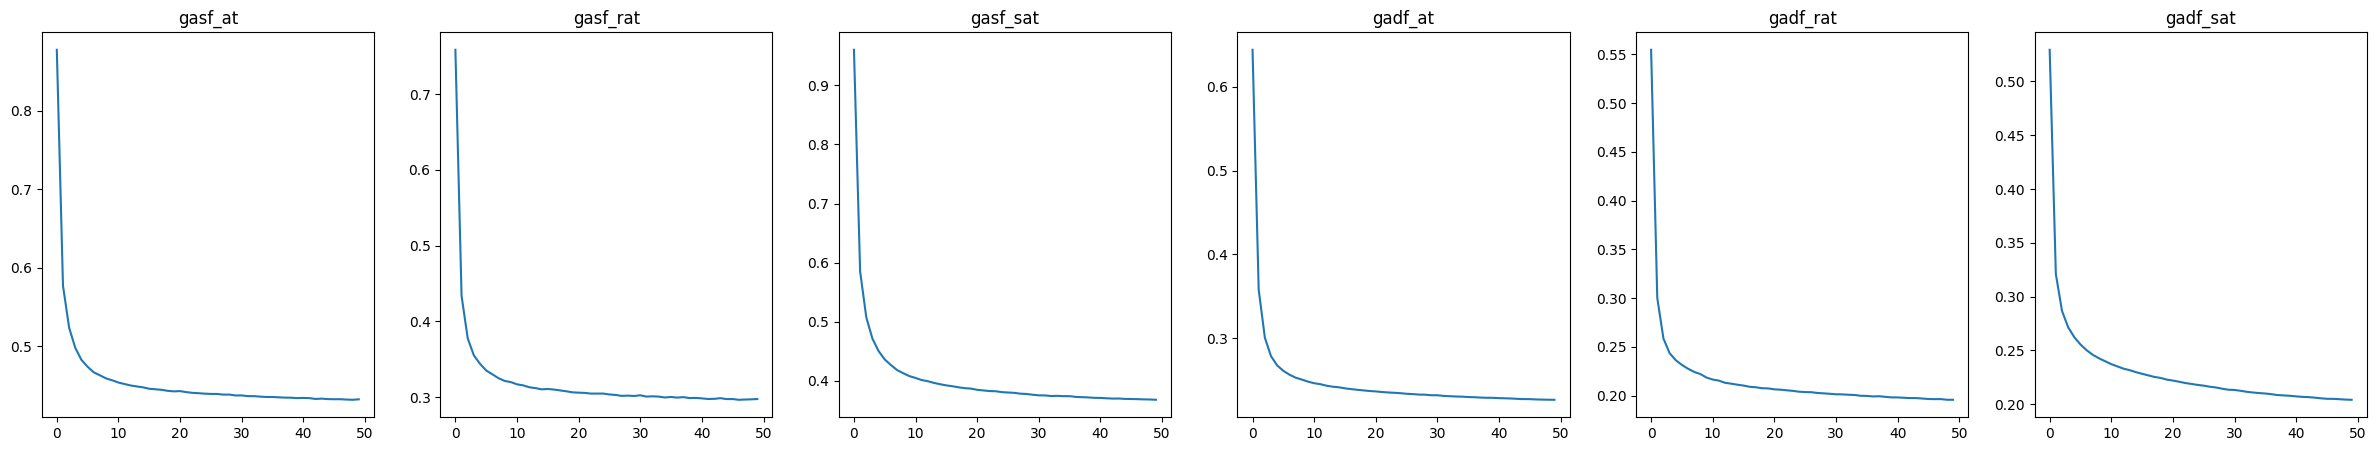

In [14]:
i = 1
plt.rcParams['figure.figsize'] = (30, 5)
for key, val in train_loss_log_dict.items():
    plt.subplot(1,6,i)
    plt.plot(val)
    plt.title(key)
    i += 1

In [15]:
def test(test, model):
    test_loss_log = []
    model.eval()
    loss_func = nn.MSELoss()

    with torch.no_grad():
        for data in tqdm(test):
            image = data[0].unsqueeze(0)
            output = model(image)
            loss = loss_func(output, image)
            test_loss_log.append([loss.item(), data[1]])
        return test_loss_log

In [16]:
test_loss_log_dict = {}

for key, val in test_dict.items():
    test_loss_log_dict[key] = test(val, model_dict[key])

100%|██████████| 101/101 [00:00<00:00, 410.51it/s]


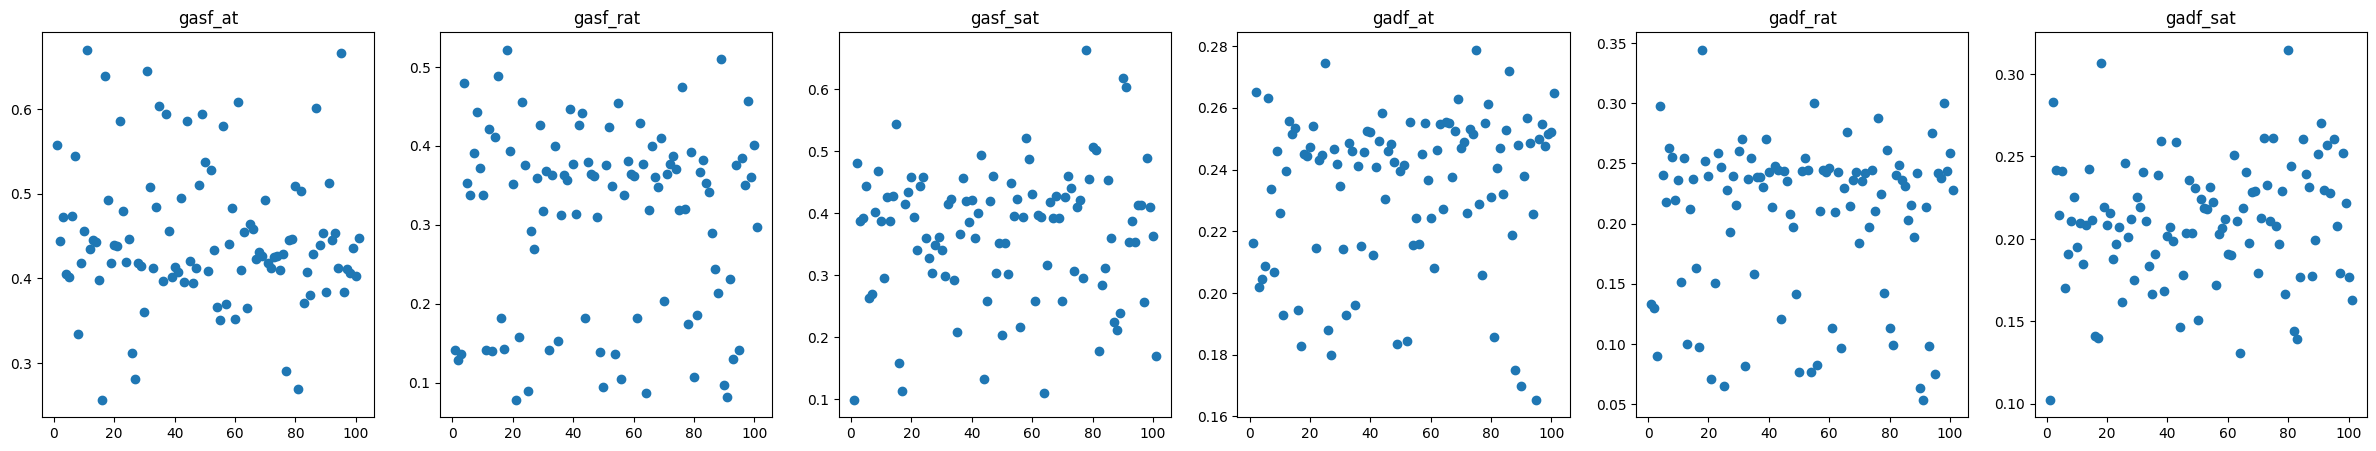

In [17]:
i = 1

for key, val in test_loss_log_dict.items():
    test_loss_log = [x[0] for x in val]
    plt.subplot(1,6,i)
    plt.scatter(x=range(1, len(test_loss_log)+1), y=test_loss_log)
    plt.title(key)
    i += 1

In [32]:
final_test_data_dict = {}

for key, val in test_dict.items():
    tmp_dict = {}
    for i in range(len(val)):
          tmp_dict[i] = [val[i][0].tolist(), test_loss_log_dict[key][i]]
    final_test_data_dict[key] = tmp_dict

In [34]:
with open('../data/test_result_data.json', 'w') as f:
    json.dump(final_test_data_dict, f, indent=4) # index 0: image_array, index 1: loss